In [2]:
import gym
import collections
import random
import time
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import *
from IPython.display import clear_output
import time
import csv
from gym import envs
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential, load_model
from keras import regularizers, optimizers
from keras.utils import to_categorical
#np.random.seed(1234)
import scipy.io as sio
import scipy as scp
from scipy import stats
import operator
from keras import backend as K
import tensorflow as tf
import os
import keras
from keras.models import load_model
from IPython.display import display, clear_output
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
#config=tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction=0.5
#set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
#all_envs = envs.registry.all()
#env_ids = [env_spec.id for env_spec in all_envs]
#print(np.transpose(env_ids)) 

In [3]:
# FF
class DQNAgent:
    def __init__(self):
        #(210,160,3),6
        self.drop = 0
        self.state_size = (128,)
        self.action_size = 4 # 9 for pacman, 6 for space invader
        self.memory = collections.deque(maxlen=1000000)
        self.gamma = 0.98    # discount rate 0.95
        self.epsilon = 1  # exploration rate 1 
        self.epsilon_min = 0.1
        self.epsilon_decay = []
        self.learning_rate = []
        self.time_penalty = 0
        self.model = []
        self.fix = False
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        
        model.add(Dense(128, input_shape=self.state_size, activation='relu'))
        #model.add(Dropout(self.drop))
                
        model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))
        
        model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))

        #model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))
        
        model.add(Dense(self.action_size, activation='linear'))
        
        #model.compile(loss='mse', optimizer=RMSprop(lr=self.learning_rate,rho=0.9,epsilon=None, decay = 0.0))
        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            act_values = np.zeros((1,self.action_size))
            return act_values,env.action_space.sample()
        state = np.expand_dims(state,axis=0)
        #print(state.shape)
        act_values = self.model.predict(state)
        
        return act_values,np.argmax(act_values)   # returns action
    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = np.expand_dims(state,axis=0)
            next_state = np.expand_dims(next_state,axis=0)
            target = 0 #if we are done the final reward is our target
            if not done: #if we are not done the target is the current reward plut the predicted reward from the next state
                target = reward + self.gamma * np.amax(self.model.predict(next_state)) 
                #print(self.gamma * np.amax(self.model.predict(next_state)))
            target_f = self.model.predict(state) 
            #print(target_f)
            target_f[0][action] = target - self.time_penalty
            
            if self.fix == False:    

                self.model.fit(state, target_f, epochs=1, verbose=0)
                
        if self.fix == False:
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

In [4]:
def train_agent(agent,env,episodes,iteration,iterations,fix):
    total_reward_counter = np.empty([episodes])
    Q_reward_counter = np.empty([episodes])
    #agent.epsilon = 1
    for e in range(episodes):
        
        if e > fix: 
            agent.fix = False
        
        total_reward = 0
        state = env.reset()
        state, reward, done, info = env.step(0)
        state = state/256
        
        for time_t in range(10000):

            
            actvals, action = agent.act(state)

            next_state, reward, done, info = env.step(action)
            next_state = next_state/256
            
            if reward>0:
                reward = 1
            
            total_reward = total_reward + reward   

            agent.remember(state, action, reward, next_state, done)
            state = next_state

            if done:
                clear_output(wait=True)
                print("iteration: {}/{}, episode: {}/{}, score: {}, epsilon: {}".format(iteration+1,iterations ,e+1, episodes, total_reward, agent.epsilon))
                Q_reward_counter[e] = np.max(actvals)
                total_reward_counter[e] = total_reward

                break
        agent.replay(32)
    return Q_reward_counter, total_reward_counter

In [5]:
#env = gym.make('SpaceInvaders-v0')
env = gym.make('Breakout-ramDeterministic-v0')
balls = np.zeros(1000)
for i in  range(1000):
    balls[i] = env.action_space.sample()
print(np.max(balls)+1)
state = env.reset()
next_state, reward, done, info = env.step(1)
lives_before = info['ale.lives']
print(info)
state.shape

4.0
{'ale.lives': 5}


(128,)

In [6]:
fix = 150
episodes = 150000 # 100.000


learning_rates = [0.002]
decay = [0.99992]#,0.99992,0.99992]   #30.000eps

iterations = 1

total_rewards = np.empty([iterations,episodes])
Q_rewards = np.empty([iterations,episodes])

for iteration in range(iterations):
    env = gym.make('Breakout-ramDeterministic-v0')
    agent = DQNAgent() 
    
    agent.fix = True
        
    #Decay parameter
    agent.epsilon_decay = decay[iteration]
    
    agent.learning_rate = learning_rates[iteration]
    agent.model = agent._build_model()
    
    Q_reward_counter, total_reward_counter = train_agent(agent,env,episodes,iteration,iterations,fix)
    
    total_rewards[iteration][:] = total_reward_counter
    Q_rewards[iteration][:] = Q_reward_counter


iteration: 1/1, episode: 150000/150000, score: 4.0, epsilon: 0.0999932987927909


/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


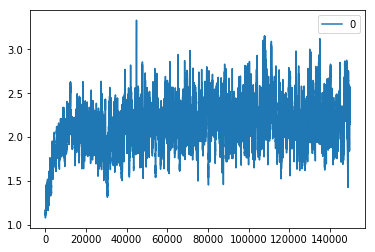

/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'Q Values')

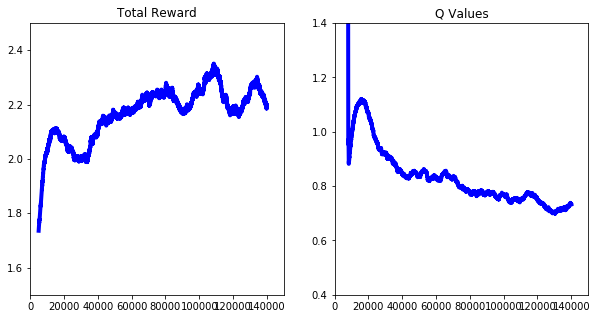

In [25]:
iterations = 1
plt.figure(figsize=(10,5))
a = subplot(121)
#iterations = 10
#iteration_value = optim
window = 5000

total_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    total_avg = np.zeros([episodes-(window*2)])
    for pnts in range(total_rewards[iteration].shape[0]-(window*2)):
        total_avg[pnts] =  np.mean(total_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(total_avg))
    total_avg_all[iteration] = total_avg 
#legend()
plt.plot(np.mean(total_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 1.5, 2.5])
title('Total Reward')
subplot(122)

#iteration_value = optim

rew_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    rew_avg = np.zeros([episodes-(window*2)])
    for pnts in range(Q_rewards[iteration].shape[0]-(window*2)):
        rew_avg[pnts] =  np.mean(Q_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(rew_avg))
    rew_avg_all[iteration] = rew_avg 
#legend()
plt.plot(np.mean(rew_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 0.4, 1.4])
title('Q Values')

In [13]:
np.savetxt('total_reward3.csv',np.transpose(total_rewards),delimiter=",")

In [23]:
agent.model.save('breakoutfeedforwardRAM150k.h5')

In [ ]:
# iterations = 1
# window = 1000

# #x = np.arange(episodes)
# for iteration in range(iterations):
#     rew_avg = np.zeros([episodes-(window*2)])
#     for pnts in range(total_rewards[iteration].shape[0]-(window*2)):
#         rew_avg[pnts] =  np.mean(total_rewards[iteration][(pnts-window) : pnts+window])

#     perf, = plt.plot(np.float32(rew_avg),label = iteration)
# legend()

In [10]:
# window = 50
# rew_avg = np.empty([episodes])
# for pnts in range(window,total_reward_counter.shape[0]):
#     rew_avg[pnts] =  np.mean(total_reward_counter[(pnts-window) : pnts+window])
# plt.plot(total_reward_counter)
# plt.plot(rew_avg)
# plt.axis([0, total_reward_counter.shape[0], np.min(rew_avg), np.max(rew_avg)])
# np.argmax(rew_avg)

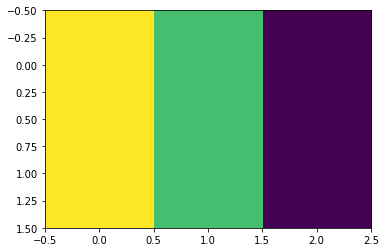

7.0
584


In [ ]:
#playtest
frms = 0
env = gym.make('Breakout-ramDeterministic-v0')
print(env)
agent = DQNAgent()
agent.model = keras.models.load_model('breakoutfeedforwardRAM150k.h5')

#envisual = gym.make('BreakoutDeterministic-v0')
state = env.reset()
#statevisual = envisual.reset()



plt.ion()
fig = plt.figure()


plt.axis([0, 432, 0, 288])
agent.epsilon = 0.1;
actgrid = [[0,0,0],[0,0,0]]
tot_rew = 0
#for e in range(10000):
#    state = env.reset()
#statevisual = envisual.reset()
for time_t in range(10000):
    clear_output(wait=True)

    #state = np.expand_dims(state,axis=4)


    actvals, action = agent.act(state)
    state = np.expand_dims(state,axis=0)
    expectation = np.amax(agent.model.predict(state))
    #print(state)

    #print(agent.model.predict(np.random.rand(1,128)))

    #actgrid[0][0] = actvals[0][5]
    #actgrid[0][1] = actvals[0][1]
    #actgrid[0][2] = actvals[0][4]

    actgrid[0][0] = actvals[0][3]
    actgrid[0][1] = actvals[0][0]
    actgrid[0][2] = actvals[0][2]

    actgrid[1][0] = actvals[0][3]
    actgrid[1][1] = actvals[0][0]
    actgrid[1][2] = actvals[0][2]

    #actgrid[2][0] = actvals[0][8]
    #actgrid[2][1] = actvals[0][4]
    #actgrid[2][2] = actvals[0][7]

    #action = 3
    state, reward1, done, _ = env.step(action)
    tot_rew = tot_rew+reward1
    #statevisual, reward2, done, info = envisual.step(action)
    #state, reward, done, _ = env.step(0)

    #print(actvals)
    #print(actgrid)

    #f, axarr = plt.subplots(1,2)

    #cmap = colors.Colormap('magma',N = 256)
    #norm = colors.Normalize(np.min(actgrid),np.max(actgrid),clip=True)
    #print(actgrid)
    #print(zactgrid)
    #axarr[0].imshow(actgrid,vmin = np.min(actgrid), vmax = np.max(actgrid))
    plt.imshow(actgrid,vmin = np.min(actgrid), vmax = np.max(actgrid))
    #axarr[1].imshow(statevisual)
    env.render()



    plt.show()
    #print(action)
    #print(expectation)
    #print(info)
    print(tot_rew)
    print(frms)
    #print(reward2)
    #time.sleep(0.001)
    #print(action)


    frms = frms+1

    if done:
        env.close()
        break
        

In [12]:
#agent.model.save('breakoutfeedforwardRAM10k.h5')